In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import pymorphy2
import pymystem3
import re
import numpy as np

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score, StratifiedKFold, validation_curve, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

In [3]:
import matplotlib.pyplot as plt


%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
def set_answer(predictions, file_name):
    dataframe = pd.DataFrame(predictions, columns=['target'], index=np.arange(200000, 370179))
    dataframe.to_csv('data/'+str(file_name)+'.csv', index_label='id')

In [5]:
def get_data(processed=False):
    if processed:
        train_data = pd.read_csv('data/train_processed2.csv', sep='\t', index_col='id')
        test_data = pd.read_csv('data/test_processed.csv', sep='\t', index_col='id') 
    else:
        train_data = pd.read_csv('data/train.csv', sep='\t', index_col='id')
        test_data = pd.read_csv('data/test.csv', sep='\t', index_col='id') 
    return (train_data, test_data)

In [6]:
## Токенизатор

def get_lemmas(text):    
    #text = BeautifulSoup(text, 'lxml').get_text()       
    #lemms = [morph.parse(w)[0].normal_form for w in text.split()]    
    lemms = [w for w in text.split()]    
    return " ".join([x for x in lemms if (re.match('^[a-zа-яё]+(-[a-zа-яё]+)*$', x) and len(x)>2)])
       
def getVacanciesLemmas(texts):  
    texts = np.array(texts)    
    processed = np.vectorize(get_lemmas, otypes=[str])              
    return processed(texts)

In [7]:
## Функция для красивого вывода наиболее оптимальных параметров обучения
def print_test_results(SearchCV, num=10, top=True):    
    if top :return pd.DataFrame(SearchCV.cv_results_).sort_values(by='mean_test_score', ascending=False).head(num).T
    return pd.DataFrame(SearchCV.cv_results_).sort_values(by='mean_test_score', ascending=False).tail(num).T

In [116]:
def get_vocabulary(corpus):
    vectorizer = CountVectorizer(ngram_range=(1, 2))
    vectorizer.fit(corpus)
    return vectorizer.vocabulary_

In [8]:
train_data, test_data = get_data(True)ффф

In [ ]:
pd.set_option('max_colwidth',  1000)
train_data.tail(20)

In [ ]:
train_data.head()

In [10]:
X_train, X_test, y_train, y_test = train_test_split((train_data.iloc[:, [-2:]].values),
                                                    train_data.iloc[:, -3].values, 
                                                    test_size=0.33, random_state=42, shuffle=True)

In [68]:
print (len(np.where(y_train==1)[0])*0.5, len(np.where(y_train==0)[0])*0.5)

31274.0 35726.0


In [106]:
np.random.seed(1001)

positive_ind = np.random.choice(np.where(y_train==1)[0], int(len(np.where(y_train==1)[0])*0.5))
negative_ind = np.random.choice(np.where(y_train==0)[0], int(len(np.where(y_train==0)[0])*0.5))

rand_ind = np.hstack(( positive_ind, negative_ind))

In [107]:
rand_ind.sort()

In [108]:
X = X_train[rand_ind]
y = y_train[rand_ind]

In [117]:
pos_vocabulary = get_vocabulary(X_train[positive_ind])

In [83]:
print (len(np.where(y==1)[0]), len(np.where(y==0)[0]))

31274 35726


In [84]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

## Оценка SGD Classifier

In [113]:
sgd_clf = Pipeline([
    ('vect', CountVectorizer(vocabulary=pos_vocabulary)),    
    ('clf', SGDClassifier(random_state=42, n_jobs=-1, alpha=0.001))
])

Alpha:  0.001


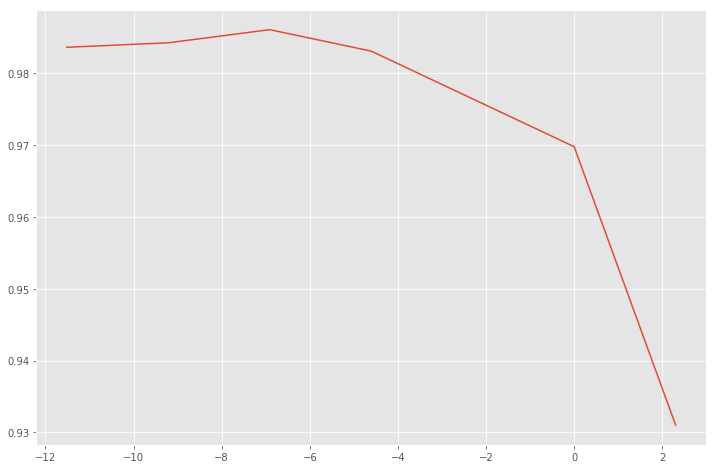

In [86]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 1, 10]
_, sgd_clf_alpha_test_scores = validation_curve(sgd_clf, X, y, 
                                                param_name='clf__alpha', param_range=alpha, 
                                                scoring='roc_auc', cv=cv, n_jobs=2)

plt.plot(np.log(alpha), sgd_clf_alpha_test_scores.mean(axis=1))
print("Alpha: ", alpha[np.where(sgd_clf_alpha_test_scores.mean(axis=1) == sgd_clf_alpha_test_scores.mean(axis=1).max())[0][0]])

In [114]:
sgd_clf.fit(X, y)
test_predict = sgd_clf.predict(X_test)


print("ROC AUC Score: ", roc_auc_score(y_test, test_predict))

C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


ROC AUC Score:  0.956062382267


In [ ]:
parameters = [
    {  
        'vect': TfidfVectorizer(),
        'vect__min_df': (0.01, 0.1, 0.5)
        'vect__max_df': (1.0, 0.8, 0.5),
        'vect__ngram_range': [(1,1), (1,2), (1,3)],
        'tfidf__norm': ('l1', 'l2', None),
        'tfidf__use_idf': (True, False),
        'tfidf__smooth_idf': (True, False),
        'clf__loss': ('hinge', 'log'),    
        'clf__fit_intercept': (True, False)
    },
    {        
        'vect__min_df': (0.01, 0.1, 0.5)
        'vect__max_df': (1.0, 0.8, 0.5),
        'vect__ngram_range': [(1,1), (1,2), (1,3)],
        'clf__loss': ('hinge', 'log'),    
        'clf__fit_intercept': (True, False)
    }
]
    

In [ ]:
sgd_gs_clf = RandomizedSearchCV(sgd_clf, parameters, n_jobs=-1, cv=cv, scoring='roc_auc', random_state=123, n_iter=15)

In [ ]:
%%time

sgd_gs_clf.fit(X, y).best_score_

In [ ]:
print_test_results(sgd_gs_clf)

## Оценка Forest

In [131]:
frst_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), vocabulary=pos_vocabulary)),
                     ('clf', RandomForestClassifier(random_state=123, n_jobs=-1,                                                 
                                                    n_estimators=1000,  
                                                    verbose=1,
                                                  ))
])

In [132]:
frst_clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 48.3min finished


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...ators=1000, n_jobs=-1,
            oob_score=False, random_state=123, verbose=1, warm_start=False))])

In [133]:
test_predict = frst_clf.predict(X_test)
print("ROC AUC Score: ", roc_auc_score(y_test, test_predict))

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   14.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   25.7s


ROC AUC Score:  0.965892695056


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:   32.8s finished


In [11]:
frst_clf = Pipeline([('vect', CountVectorizer(min_df = 100, max_df=0.5, stop_words=['год', 'ооо'])),
                     ('tfidf', TfidfTransformer(smooth_idf=False)),
                     ('clf', RandomForestClassifier(random_state=123, n_jobs=-1, 
                                                    criterion='entropy', 
                                                    n_estimators=1300,  
                                                    verbose=1,
                                                    max_depth=25, min_samples_leaf=1,
                                                    min_samples_split=10,
                                                  ))
])

In [12]:

cross_val_score(frst_clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

array([ 0.9880641 ,  0.98823835,  0.98806061])

In [ ]:
estimators = np.linspace(100, 2000, 10, dtype=int)

_, forest_estimators_test_scores = validation_curve(frst_clf, X[:4000], y[:4000], param_name='clf__n_estimators', param_range=estimators, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
plt.plot(estimators, forest_estimators_test_scores.mean(axis=1))

In [ ]:
depths = range(1, 50, 10)
_, forest_max_depth_test_scores = validation_curve(frst_clf, X[:4000], y[:4000], param_name='clf__max_depth', param_range=depths, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
plt.plot(depths, forest_max_depth_test_scores.mean(axis=1))

In [ ]:
%%time

min_df = np.linspace(20, 500, 20, dtype=int)

_, forest_min_df_test_scores = validation_curve(frst_clf, X, y, param_name='vect__min_df', param_range=min_df, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
plt.plot(min_df, forest_min_df_test_scores.mean(axis=1))
#print(min_df[np.where(forest_min_df_test_scores.max())], min_df, forest_min_df_test_scores.mean(axis=1).max())
print("Min_df: ", min_df[np.where(forest_min_df_test_scores.mean(axis=1) == forest_min_df_test_scores.mean(axis=1).max())])

In [ ]:
parameters = {    
    #'vect__max_df': (1.0, 0.8, 0.5),
    #'vect__min_df': (100, 500),
    'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__norm': (None, 'l2', 'l1'),
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),    
    #'clf__n_estimators': np.linspace(900, 2500, 5, dtype=int),
    #'clf__criterion': ('entropy', 'gini'),
    #'clf__max_depth': np.linspace(10, 30, 5, dtype=int),
    #'clf__min_samples_split': (2, 10, 20),
    #'clf__min_samples_leaf': (1, 10, 50),   
}

In [ ]:
frst_gs_clf = RandomizedSearchCV(frst_clf, parameters, n_jobs=-1, cv=cv, scoring='roc_auc', random_state=123, n_iter=10)

In [ ]:
%%time

frst_gs_clf.fit(X, y).best_score_

In [ ]:
print_test_results(frst_gs_clf)

In [16]:
frst_clf2 = Pipeline([('vect', CountVectorizer(min_df = 100, max_df=0.7)),                     
                     ('clf', RandomForestClassifier(random_state=123, n_jobs=-1, 
                                                    criterion='entropy', 
                                                    n_estimators=1300,                                                     
                                                    max_depth=25, min_samples_leaf=1,
                                                    min_samples_split=10,
                                                    ))
])

In [17]:
frst_clf = None

In [18]:
del(frst_clf)

In [ ]:
# stop_words=['год', 'ооо']
parameters = {    
    #'vect__max_df': (1.0, 0.8, 0.5),
    #'vect__min_df': (100, 500),
    #'vect__ngram_range': [(1,1), (1,2), (1,3)], 
    #'clf__n_estimators': np.linspace(900, 2500, 5, dtype=int),
    #'clf__criterion': ('entropy', 'gini'),
    #'clf__max_depth': np.linspace(10, 30, 5, dtype=int),ф
    #'clf__min_samples_split': (2, 10, 20),
    #'clf__min_samples_leaf': (1, 10, 50),   
}

In [19]:
if __name__ == "__main__":   
    cross_val_score(frst_clf2, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

JoblibMemoryError: JoblibMemoryError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Anaconda\lib\runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...nda\\lib\\site-packages\\ipykernel\\__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Anaconda\lib\runpy.py in _run_code(code=<code object <module> at 0x0000023391BD4780, fil...lib\site-packages\ipykernel\__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Anaconda\lib\site-packages\ipykernel\__pycache__\__main__.cpython-36.pyc', '__doc__': None, '__file__': r'C:\Anaconda\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...nda\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Anaconda\\lib\\site-packages\\ipykernel\\kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...nda\\lib\\site-packages\\ipykernel\\__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000023391BD4780, fil...lib\site-packages\ipykernel\__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Anaconda\lib\site-packages\ipykernel\__pycache__\__main__.cpython-36.pyc', '__doc__': None, '__file__': r'C:\Anaconda\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...nda\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Anaconda\\lib\\site-packages\\ipykernel\\kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Anaconda\lib\site-packages\ipykernel\__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
C:\Anaconda\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Anaconda\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Anaconda\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Anaconda\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Anaconda\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Anaconda\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Anaconda\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Anaconda\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Anaconda\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Anaconda\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Anaconda\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'if __name__ == "__main__":   \n    cross_val_scor..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 7, 20, 5, 23, 805298, tzinfo=tzutc()), 'msg_id': 'FD2B2435930947858AA95BEA4373A1F4', 'msg_type': 'execute_request', 'session': '4A5F545404194DA880F38A84F572B8AE', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'FD2B2435930947858AA95BEA4373A1F4', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'4A5F545404194DA880F38A84F572B8AE']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'if __name__ == "__main__":   \n    cross_val_scor..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 7, 20, 5, 23, 805298, tzinfo=tzutc()), 'msg_id': 'FD2B2435930947858AA95BEA4373A1F4', 'msg_type': 'execute_request', 'session': '4A5F545404194DA880F38A84F572B8AE', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'FD2B2435930947858AA95BEA4373A1F4', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
C:\Anaconda\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'4A5F545404194DA880F38A84F572B8AE'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'if __name__ == "__main__":   \n    cross_val_scor..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 7, 20, 5, 23, 805298, tzinfo=tzutc()), 'msg_id': 'FD2B2435930947858AA95BEA4373A1F4', 'msg_type': 'execute_request', 'session': '4A5F545404194DA880F38A84F572B8AE', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'FD2B2435930947858AA95BEA4373A1F4', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Anaconda\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='if __name__ == "__main__":   \n    cross_val_scor..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'if __name__ == "__main__":   \n    cross_val_scor..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\Anaconda\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('if __name__ == "__main__":   \n    cross_val_scor..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('if __name__ == "__main__":   \n    cross_val_scor..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='if __name__ == "__main__":   \n    cross_val_scor..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.If object>], cell_name='<ipython-input-19-ba18760b29c7>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 233a9170e80, executio..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x00000233A911A300, file "<ipython-input-19-ba18760b29c7>", line 1>
        result = <ExecutionResult object at 233a9170e80, executio..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x00000233A911A300, file "<ipython-input-19-ba18760b29c7>", line 1>, result=<ExecutionResult object at 233a9170e80, executio..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x00000233A911A300, file "<ipython-input-19-ba18760b29c7>", line 1>
        self.user_global_ns = {'BeautifulSoup': <class 'bs4.BeautifulSoup'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'FeatureUnion': <class 'sklearn.pipeline.FeatureUnion'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nfrom bs4 import BeautifulSou...hy2\nimport pymystem3\nimport re\nimport numpy as np', 'from sklearn.pipeline import Pipeline\nfrom sklea...import roc_auc_score, confusion_matrix, roc_curve', "import matplotlib.pyplot as plt\n\n\nget_ipython()....ggplot')\nplt.rcParams['figure.figsize'] = (12, 8)", "def set_answer(predictions, file_name):\n    data...('data/'+str(file_name)+'.csv', index_label='id')", "def get_data(processed=False):\n    if processed:...dex_col='id') \n    return (train_data, test_data)", '## Токенизатор \n\nmorph = pymorphy2.MorphAnalyzer...=[str])              \n    return processed(texts)', "## Функция для красивого вывода наиболее оптимал...y='mean_test_score', ascending=False).tail(num).T", 'train_data, test_data = get_data(True)', 'X_train, X_test, y_train, y_test = train_test_sp...   test_size=0.33, random_state=42, shuffle=True)', 'cv = StratifiedKFold(n_splits=3, random_state=123, shuffle=True)', "frst_clf = Pipeline([('vect', CountVectorizer(mi...                                            ))\n])", "cross_val_score(frst_clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)", "frst_clf2 = Pipeline([('vect', CountVectorizer(m...                                            ))\n])", 'if __name__ == "__main__"::    \n    cross_val_sc..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)', 'if __name__ == "__main__":   \n    cross_val_scor..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)', "frst_clf2 = Pipeline([('vect', CountVectorizer(m...                                            ))\n])", 'frst_clf = None', 'del(frst_clf)', 'if __name__ == "__main__":   \n    cross_val_scor..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)'], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {12: array([ 0.9880641 ,  0.98823835,  0.98806061])}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, ...}
        self.user_ns = {'BeautifulSoup': <class 'bs4.BeautifulSoup'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'FeatureUnion': <class 'sklearn.pipeline.FeatureUnion'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nfrom bs4 import BeautifulSou...hy2\nimport pymystem3\nimport re\nimport numpy as np', 'from sklearn.pipeline import Pipeline\nfrom sklea...import roc_auc_score, confusion_matrix, roc_curve', "import matplotlib.pyplot as plt\n\n\nget_ipython()....ggplot')\nplt.rcParams['figure.figsize'] = (12, 8)", "def set_answer(predictions, file_name):\n    data...('data/'+str(file_name)+'.csv', index_label='id')", "def get_data(processed=False):\n    if processed:...dex_col='id') \n    return (train_data, test_data)", '## Токенизатор \n\nmorph = pymorphy2.MorphAnalyzer...=[str])              \n    return processed(texts)', "## Функция для красивого вывода наиболее оптимал...y='mean_test_score', ascending=False).tail(num).T", 'train_data, test_data = get_data(True)', 'X_train, X_test, y_train, y_test = train_test_sp...   test_size=0.33, random_state=42, shuffle=True)', 'cv = StratifiedKFold(n_splits=3, random_state=123, shuffle=True)', "frst_clf = Pipeline([('vect', CountVectorizer(mi...                                            ))\n])", "cross_val_score(frst_clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)", "frst_clf2 = Pipeline([('vect', CountVectorizer(m...                                            ))\n])", 'if __name__ == "__main__"::    \n    cross_val_sc..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)', 'if __name__ == "__main__":   \n    cross_val_scor..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)', "frst_clf2 = Pipeline([('vect', CountVectorizer(m...                                            ))\n])", 'frst_clf = None', 'del(frst_clf)', 'if __name__ == "__main__":   \n    cross_val_scor..., scoring=\'roc_auc\', cv=cv, n_jobs=-1, verbose=1)'], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {12: array([ 0.9880641 ,  0.98823835,  0.98806061])}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
C:\Users\ml-unifam\notebooks\hw_05\<ipython-input-19-ba18760b29c7> in <module>()
      1 if __name__ == "__main__":   
----> 2     cross_val_score(frst_clf2, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

...........................................................................
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py in cross_val_score(estimator=Pipeline(memory=None,
     steps=[('vect', Count...random_state=123, verbose=0, warm_start=False))]), X=array([ 'менеджер продажа лакокрасочный материал...сделать сейчас вакансия'], 
      dtype='<U8417'), y=array([1, 0, 0, ..., 0, 1, 1], dtype=int64), groups=None, scoring='roc_auc', cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True), n_jobs=-1, verbose=1, fit_params=None, pre_dispatch='2*n_jobs')
    337     cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
    338                                 scoring={'score': scorer}, cv=cv,
    339                                 return_train_score=False,
    340                                 n_jobs=n_jobs, verbose=verbose,
    341                                 fit_params=fit_params,
--> 342                                 pre_dispatch=pre_dispatch)
        pre_dispatch = '2*n_jobs'
    343     return cv_results['test_score']
    344 
    345 
    346 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py in cross_validate(estimator=Pipeline(memory=None,
     steps=[('vect', Count...random_state=123, verbose=0, warm_start=False))]), X=array([ 'менеджер продажа лакокрасочный материал...сделать сейчас вакансия'], 
      dtype='<U8417'), y=array([1, 0, 0, ..., 0, 1, 1], dtype=int64), groups=None, scoring={'score': make_scorer(roc_auc_score, needs_threshold=True)}, cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True), n_jobs=-1, verbose=1, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False)
    201     scores = parallel(
    202         delayed(_fit_and_score)(
    203             clone(estimator), X, y, scorers, train, test, verbose, None,
    204             fit_params, return_train_score=return_train_score,
    205             return_times=True)
--> 206         for train, test in cv.split(X, y, groups))
        cv.split = <bound method StratifiedKFold.split of StratifiedKFold(n_splits=3, random_state=123, shuffle=True)>
        X = array([ 'менеджер продажа лакокрасочный материал...сделать сейчас вакансия'], 
      dtype='<U8417')
        y = array([1, 0, 0, ..., 0, 1, 1], dtype=int64)
        groups = None
    207 
    208     if return_train_score:
    209         train_scores, test_scores, fit_times, score_times = zip(*scores)
    210         train_scores = _aggregate_score_dicts(train_scores)

...........................................................................
C:\Anaconda\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object cross_validate.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
MemoryError                                        Wed Mar  7 20:06:32 2018
PID: 884                               Python 3.6.3: C:\Anaconda\python.exe
...........................................................................
C:\Anaconda\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('vect', Count...random_state=123, verbose=0, warm_start=False))]), memmap([ 'менеджер продажа лакокрасочный материа...сделать сейчас вакансия'], 
      dtype='<U8417'), memmap([1, 0, 0, ..., 0, 1, 1], dtype=int64), {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([     0,      1,      2, ..., 133997, 133998, 133999]), array([     6,      7,     12, ..., 133987, 133988, 133995]), 1, None, None), {'return_times': True, 'return_train_score': False})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Anaconda\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('vect', Count...random_state=123, verbose=0, warm_start=False))]), memmap([ 'менеджер продажа лакокрасочный материа...сделать сейчас вакансия'], 
      dtype='<U8417'), memmap([1, 0, 0, ..., 0, 1, 1], dtype=int64), {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([     0,      1,      2, ..., 133997, 133998, 133999]), array([     6,      7,     12, ..., 133987, 133988, 133995]), 1, None, None)
        kwargs = {'return_times': True, 'return_train_score': False}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('vect', Count...random_state=123, verbose=0, warm_start=False))]), X=memmap([ 'менеджер продажа лакокрасочный материа...сделать сейчас вакансия'], 
      dtype='<U8417'), y=memmap([1, 0, 0, ..., 0, 1, 1], dtype=int64), scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=array([     0,      1,      2, ..., 133997, 133998, 133999]), test=array([     6,      7,     12, ..., 133987, 133988, 133995]), verbose=1, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=True, error_score='raise')
    444         estimator.set_params(**parameters)
    445 
    446     start_time = time.time()
    447 
    448     X_train, y_train = _safe_split(estimator, X, y, train)
--> 449     X_test, y_test = _safe_split(estimator, X, y, test, train)
        X_test = undefined
        y_test = undefined
        estimator = Pipeline(memory=None,
     steps=[('vect', Count...random_state=123, verbose=0, warm_start=False))])
        X = memmap([ 'менеджер продажа лакокрасочный материа...сделать сейчас вакансия'], 
      dtype='<U8417')
        y = memmap([1, 0, 0, ..., 0, 1, 1], dtype=int64)
        test = array([     6,      7,     12, ..., 133987, 133988, 133995])
        train = array([     0,      1,      2, ..., 133997, 133998, 133999])
    450 
    451     is_multimetric = not callable(scorer)
    452     n_scorers = len(scorer.keys()) if is_multimetric else 1
    453 

...........................................................................
C:\Anaconda\lib\site-packages\sklearn\utils\metaestimators.py in _safe_split(estimator=Pipeline(memory=None,
     steps=[('vect', Count...random_state=123, verbose=0, warm_start=False))]), X=memmap([ 'менеджер продажа лакокрасочный материа...сделать сейчас вакансия'], 
      dtype='<U8417'), y=memmap([1, 0, 0, ..., 0, 1, 1], dtype=int64), indices=array([     6,      7,     12, ..., 133987, 133988, 133995]), train_indices=array([     0,      1,      2, ..., 133997, 133998, 133999]))
    195         if train_indices is None:
    196             X_subset = X[np.ix_(indices, indices)]
    197         else:
    198             X_subset = X[np.ix_(indices, train_indices)]
    199     else:
--> 200         X_subset = safe_indexing(X, indices)
        X_subset = undefined
        X = memmap([ 'менеджер продажа лакокрасочный материа...сделать сейчас вакансия'], 
      dtype='<U8417')
        indices = array([     6,      7,     12, ..., 133987, 133988, 133995])
    201 
    202     if y is not None:
    203         y_subset = safe_indexing(y, indices)
    204     else:

...........................................................................
C:\Anaconda\lib\site-packages\sklearn\utils\__init__.py in safe_indexing(X=memmap([ 'менеджер продажа лакокрасочный материа...сделать сейчас вакансия'], 
      dtype='<U8417'), indices=array([     6,      7,     12, ..., 133987, 133988, 133995]))
    155             return X.copy().iloc[indices]
    156     elif hasattr(X, "shape"):
    157         if hasattr(X, 'take') and (hasattr(indices, 'dtype') and
    158                                    indices.dtype.kind == 'i'):
    159             # This is often substantially faster than X[indices]
--> 160             return X.take(indices, axis=0)
        X.take = <built-in method take of memmap object>
        indices = array([     6,      7,     12, ..., 133987, 133988, 133995])
    161         else:
    162             return X[indices]
    163     else:
    164         return [X[idx] for idx in indices]

MemoryError: 
___________________________________________________________________________

In [ ]:
cv_score

In [ ]:
frst_gs_clf2 = GridSearchCV(frst_clf2, parameters, n_jobs=-1, cv=cv, scoring='roc_auc')

In [ ]:
%%time 

frst_gs_clf2.fit(X, y)

In [ ]:
print_test_results(frst_gs_clf2)

## Оценка логистической регрессии

In [ ]:
np.random.seed(15546)

rand_ind = np.hstack((np.random.choice(np.where(y==1)[0], 10000), np.random.choice(np.where(y==0)[0], 10000)))

In [ ]:
X = X_train[rand_ind]
y = y_train[rand_ind]

In [ ]:
text_clf = Pipeline([
    ('vect', CountVectorizer(max_df=0.5, min_df=100, ngram_range=(1,3), max_features=4000)),
    ('tfidf',  TfidfTransformer(norm=None, smooth_idf=True, use_idf=True)),
    ('clf', LogisticRegression(random_state=42, solver='saga', max_iter=500)),
])

In [ ]:
max_iter = range(300, 1000, 100)
_, lg_max_iter_test_scores = validation_curve(text_clf, X, y, param_name='clf__max_iter', param_range=max_iter, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

plt.plot(max_iter, lg_max_iter_test_scores.mean(axis=1))

In [ ]:
C = (0.001, 0.1, 1.0)
_, lg_C_test_scores = validation_curve(text_clf, X, y, param_name='clf__C', param_range=C, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

plt.plot(C, lg_C_test_scores.mean(axis=1))

In [ ]:
max_features = range(100, 10000, 500)
_, lg_max_features_test_scores = validation_curve(text_clf, X, y, param_name='vect__max_features', param_range=max_features, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

plt.plot(max_features, lg_max_features_test_scores.mean(axis=1))

In [ ]:
parameters = {
    #'vect__ngram_range': [(1, 2), (1, 3)],                            
    'vect__max_features': (2000, 3000, 4000),
    #'clf__max_iter': (300, 500, 700, 1000),
}

In [ ]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, scoring='roc_auc')

In [ ]:
%%time
gs_clf.fit(X, y).best_score_

In [ ]:
print_test_results(gs_clf)

In [ ]:
l = gs_clf.best_estimator_

In [ ]:
a = l.steps[2][1]

In [ ]:
matrix = l.steps[0][1]
matrix.

In [ ]:
len(matrix.get_feature_names())

In [ ]:
np.hstack([matrix.get_feature_names(), a.coef_[0, :]]).reshape((4000, 2), order='F')

In [ ]:
weigts = pd.DataFrame(np.hstack([matrix.get_feature_names(), a.coef_[0, :]]).reshape((4000, 2), order='F'),
             columns=['names', 'weigts'])

In [ ]:
weigts.sort_values('weigts', ascending=True)

In [ ]:
#gs_clf.transform()

## Обучение на всей выборке

In [66]:
clf = Pipeline([('vect', CountVectorizer(min_df = 1000, max_df=0.5)),                     
                     ('clf', RandomForestClassifier(random_state=123, n_jobs=-1, 
                                                    criterion='entropy', 
                                                    n_estimators=1300,                                                     
                                                    max_depth=25, min_samples_leaf=1,
                                                    min_samples_split=10,
                                                    ))
])

In [67]:
%%time 

clf.fit(X_train, y_train)

Wall time: 7min 12s


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1000,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...ators=1300, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False))])

In [68]:
test_predictions = clf.predict(X_test)

In [69]:
roc_auc_score(y_test, test_predictions)

0.95773254405226904

In [ ]:
predict_probabilities = lgr_clf.predict_proba(X_test)

In [ ]:
predict_probabilities[:, 1].shape

In [ ]:
y_test.shape

In [ ]:
fpr, tpr, _ = roc_curve(y_test, predict_probabilities[:, 0], pos_label=0)

In [ ]:
plt.plot(fpr, tpr)

In [134]:
test_texts = getVacanciesLemmas(test_data.iloc[:, -1].values)

In [137]:
result_predictions = frst_clf.predict(test_texts)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   16.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   38.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:  1.4min finished


In [138]:
set_answer(result_predictions, 'frst_predict33')